In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
import matplotlib.ticker as ticker

In [2]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/AG_News'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_AG_News_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_SGD'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=40_rando...,40,1001,6414.779796,0.767632,0.109588
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=40_rando...,40,2001,6336.960590,0.809474,0.093005
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=40_rando...,40,3001,6513.962563,0.699868,0.150640
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=400_rand...,400,1001,7192.430218,0.867368,0.078171
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=400_rand...,400,2001,7386.085637,0.859211,0.086669
...,...,...,...,...,...,...,...
2155,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=40000_r...,40000,2001,7164.460149,0.897763,0.030573
2156,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=40000_r...,40000,3001,7098.636331,0.900789,0.029284
2157,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=120000_...,120000,1001,7277.612855,0.900132,0.028035
2158,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=120000_...,120000,2001,6867.497685,0.900395,0.030180


In [3]:
tuned_df.to_csv('tuned_AG_News_BERT-base.csv', index=False)
retrained_df.to_csv('retrained_AG_News_BERT-base.csv', index=False)

In [4]:
news4_dictionary = np.load('AG_News_BERT-base_dictionary.npy', allow_pickle=True).item()

In [5]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_elbo_tuned_df.loc[len(news4_elbo_tuned_df)] = row
    
min_indices = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_elbo_retrained_df = news4_elbo_tuned_df.loc[min_indices]
news4_elbo_retrained_df['total_time'] = news4_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [6]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_diagEF_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_laplace_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_laplace_tuned_df.loc[len(news4_laplace_tuned_df)] = row
    
min_indices = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_laplace_retrained_df = news4_laplace_tuned_df.loc[min_indices]
news4_laplace_retrained_df['total_time'] = news4_laplace_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [7]:
d = 109_485_316
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_AG_News_VI_SGD'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
criterion = 'l2-sp'
ns = [40, 400, 4_000, 40_000, 120_000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
news4_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, n, random_state in itertools.product(lr_0s, ns, random_states):
    model_name = f'{criterion}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    news4_de_elbo_tuned_df.loc[len(news4_de_elbo_tuned_df)] = row
    
min_indices = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['train_loss'].idxmin()
news4_de_elbo_retrained_df = news4_de_elbo_tuned_df.loc[min_indices]
news4_de_elbo_retrained_df['total_time'] = news4_de_elbo_tuned_df.groupby(['criterion', 'n', 'random_state'])['runtime'].sum().values   

In [8]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, color='#1F77B4', markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color=color, marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color=color, zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color=color, zorder=2)

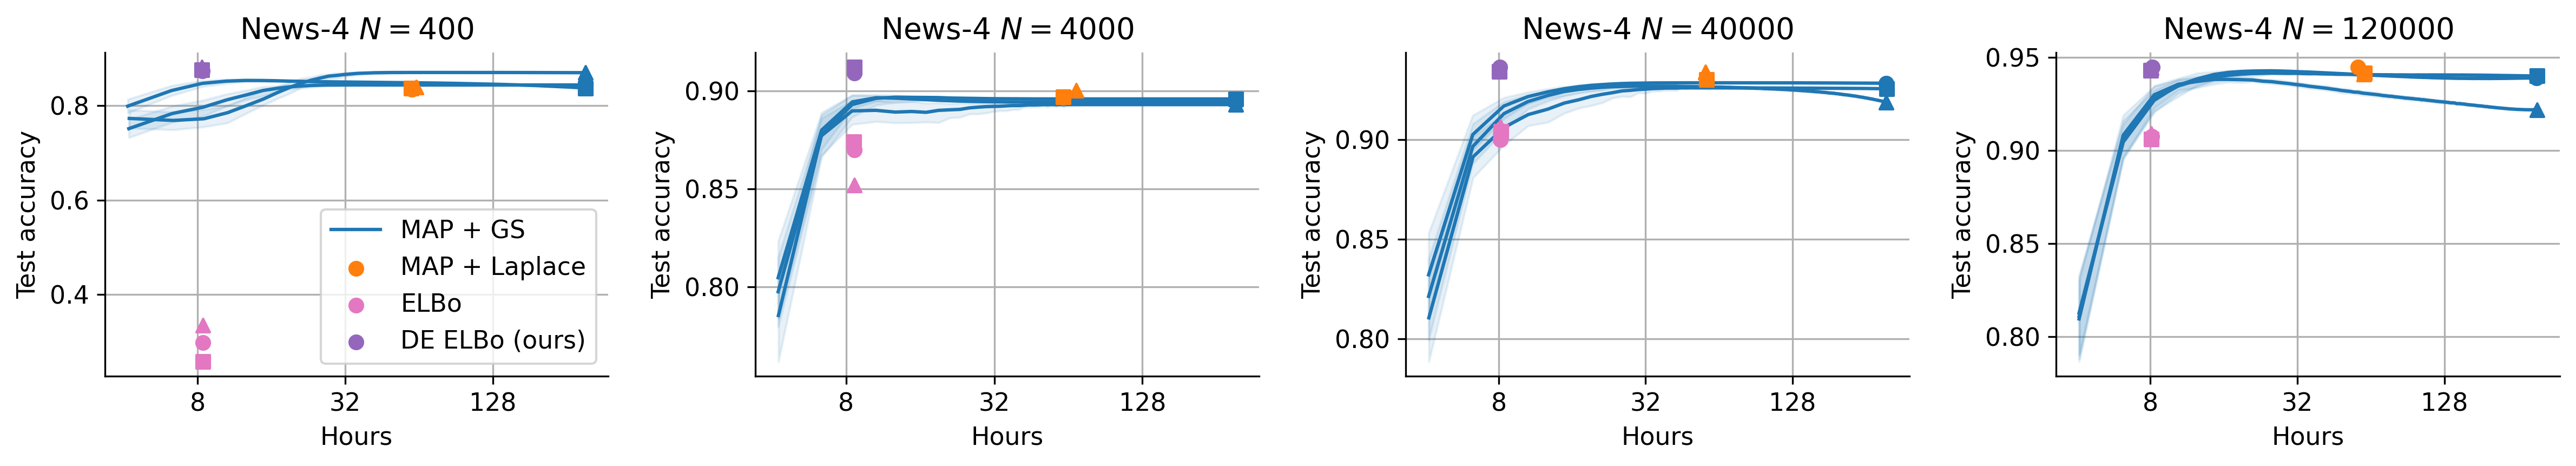

In [9]:
markers = ['o', '^', 's']

ncols, nrows = 4, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
plot_dictionary(axs[0], news4_dictionary, 400, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==400].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==400].test_acc.values)):
    axs[0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==400].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==400].test_acc.values)):
    axs[0].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==400].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==400].test_acc.values)):
    axs[0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

axs[0].set_xscale('log', base=2)
ticks = axs[0].get_xticks()
axs[0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set_title(r'News-4 $N=400$')
axs[0].set_xlabel('Hours')
axs[0].set_ylabel('Test accuracy')
axs[0].grid()

# Legend
axs[0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[0].scatter([], [], color='#FF7F0E', label='MAP + Laplace', zorder=3)
axs[0].scatter([], [], color='#E377C2', label='ELBo', zorder=3)
axs[0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
axs[0].legend(loc='lower right')

# Plot 2
plot_dictionary(axs[1], news4_dictionary, 4_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==4_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==4_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==4_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==4_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==4_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==4_000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

axs[1].set_xscale('log', base=2)
ticks = axs[1].get_xticks()
axs[1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set_title(r'News-4 $N=4000$')
axs[1].set_xlabel('Hours')
axs[1].set_ylabel('Test accuracy')
axs[1].grid()


# Plot 3
plot_dictionary(axs[2], news4_dictionary, 40_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40_000].test_acc.values)):
    axs[2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40_000].test_acc.values)):
    axs[2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40_000].test_acc.values)):
    axs[2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

axs[2].set_xscale('log', base=2)
ticks = axs[2].get_xticks()
axs[2].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].set_title(r'News-4 $N=40000$')
axs[2].set_xlabel('Hours')
axs[2].set_ylabel('Test accuracy')
axs[2].grid()

# Plot 4
plot_dictionary(axs[3], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

axs[3].set_xscale('log', base=2)
ticks = axs[3].get_xticks()
axs[3].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[3].spines[['right', 'top']].set_visible(False)
axs[3].set_title(r'News-4 $N=120000$')
axs[3].set_xlabel('Hours')
axs[3].set_ylabel('Test accuracy')
axs[3].grid()

fig.tight_layout()
fig.savefig('bert_base_uncased_computational_time_comparison.pdf', bbox_inches='tight')
plt.show()

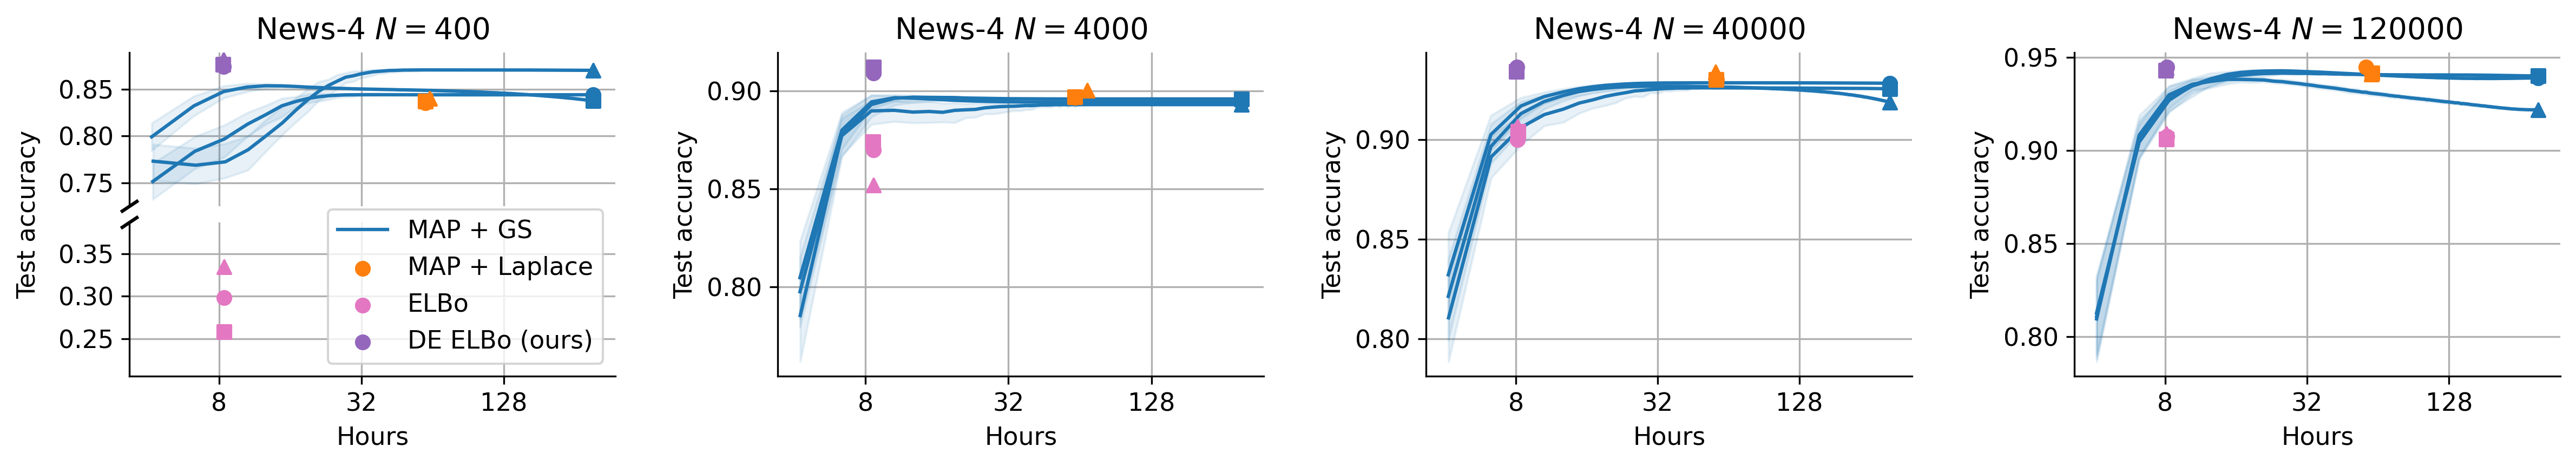

In [10]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
ncols, nrows = 4, 1
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
decorate_hidden_ax(axs[0], r'News-4 $N=400$')

ins2_top = axs[0].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins2_bottom = axs[0].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)

plot_dictionary(ins2_top, news4_dictionary, 400, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==400].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==400].test_acc.values)):
    ins2_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==400].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==400].test_acc.values)):
    ins2_top.scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==400].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==400].test_acc.values)):
    ins2_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

break_axes(axs[0])
decorate_broken_axes(ins2_top, ins2_bottom)

# Legend
axs[0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[0].scatter([], [], color='#FF7F0E', label='MAP + Laplace', zorder=3)
axs[0].scatter([], [], color='#E377C2', label='ELBo', zorder=3)
axs[0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
axs[0].legend(loc='lower right')

# Plot 2
plot_dictionary(axs[1], news4_dictionary, 4000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==4000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==4000].test_acc.values)):
    axs[1].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==4000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==4000].test_acc.values)):
    axs[1].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==4000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==4000].test_acc.values)):
    axs[1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

decorate_ax(axs[1], r'News-4 $N=4000$')

# Plot 3
plot_dictionary(axs[2], news4_dictionary, 40000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==40000].test_acc.values)):
    axs[2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

decorate_ax(axs[2], r'News-4 $N=40000$')

# Plot 4
plot_dictionary(axs[3], news4_dictionary, 120_000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].total_time.values/3600, news4_elbo_retrained_df[news4_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].total_time.values/3600, news4_laplace_retrained_df[news4_laplace_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#FF7F0E', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].total_time.values/3600, news4_de_elbo_retrained_df[news4_de_elbo_retrained_df.n==120_000].test_acc.values)):
    axs[3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

decorate_ax(axs[3], r'News-4 $N=120000$')

fig.tight_layout()
fig.savefig('bert_base_uncased_computational_time_comparison.pdf', bbox_inches='tight')
plt.show()